In [3]:
##given performance in the previous page, where should I post next?
import pandas as pd
from pandas.stats.api import ols
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import math
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.cross_validation import train_test_split
import math

from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

############ LOG SCALING - 
###PREDICTION TASK - with cross-promotion
###Cross-validation
train = pd.read_csv('jan_may_2017_links_cross_posting_info.csv')
##drop dups
# train = train.sort_values('ext_table1_firsthour_stats_date', ascending = False).drop_duplicates(subset=['buzz_post_buzz_id', 'ext_external_id'], keep = 'last')
all_pages = list(train.buzz_account_display_name.unique())

features = [
       'ext_table1_consumptions_by_type__link_clicks',
       'ext_table1_consumptions_by_type__other_clicks',
       'ext_table1_reactions_like_total',
       'ext_table1_stories_by_action_type__comment',
       'ext_table1_stories_by_action_type__like',
       'ext_table1_stories_by_action_type__share', 'ext_table1_engaged_fan',
       'ext_table1_fan_reach', 'ext_table1_impressions',
       'ext_table1_impressions_fan',
        ]

###convert to log-scale
# for feat in features:
#     train[feat] = np.log(train[feat]+1)

alt_inf = len(all_pages) + 1
train = train.replace(math.inf, alt_inf)

for pg in all_pages:
    features.append(pg)

/Users/eshwarchandrasekharan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
train.shape, train['buzz_post_buzz_id'].unique().shape

((37231, 113), (18793,))

In [5]:
###for each buzz_id, get the external ID which was posted FIRST!!!
train_grouped = train.groupby(['buzz_post_buzz_id']).agg({'buzz_post_created_at':'min'})

train_grouped = train_grouped.reset_index()

train_grouped = train_grouped.rename(columns={'buzz_post_created_at':'first_post'})

df = pd.merge(train, train_grouped, how='left', on=['buzz_post_buzz_id'])

df = df[df['buzz_post_created_at'] == df['first_post']]

In [12]:
tf = train

In [49]:
tel = train[train['buzz_post_buzz_id'] == 4456887].sort_values('buzz_post_created_at')

In [13]:
# def get_previous(X):
#     prev = -1
#     buzzid = train[train['buzz_external_id'] == X]['buzz_post_buzz_id'].values[0]    
#     created_at = train[train['buzz_external_id'] == X]['buzz_post_created_at'].values[0]    
#     tf = train[(train['buzz_post_buzz_id'] == buzzid)&(train['buzz_post_created_at'] < created_at)]
# #     print(len(tf))
#     if len(tf) < 1:
#         return -1
#     else:
#         prev = tf[-1:]['buzz_external_id'].values[0]
#         return prev

def get_previous(X):
#     print("Start")
    buzzid = train[train['buzz_external_id'] == X]['buzz_post_buzz_id'].values[0]
    cross_posts = list(train[train['buzz_post_buzz_id'] == buzzid].sort_values(['buzz_post_created_at'], ascending = True)['buzz_external_id']) 
    
#     print(cross_posts)
    index = cross_posts.index(X)
    if index == 0:
        return -1
#         return "-1"
    else:
        return cross_posts[index - 1]

tf['previous_external_id'] = tf['buzz_external_id'].apply(get_previous)

In [18]:
tf.to_csv('previous-page-info.csv', index = False)

In [19]:
####use performance in 1st hour on previous page to predict performance in 1st hour, 
####given a new page where it might get posted on!
tf.columns

Index(['buzz_external_id', 'buzz_post_parent_external_id',
       'buzz_post_created_at', 'buzz_account_display_name',
       'buzz_post_type_name', 'buzz_post_buzz_id', 'buzz_campaign_uri',
       'buzz_campaign_name', 'ext_table1_stats_date', 'ext_external_id',
       ...
       'BuzzFeed Sweaty', 'Tasty Junior', 'Oh Great, More Politics',
       'Einfach Tasty', 'BuzzFeed Steven L.', 'The Try Guys', 'Ohmygod Yaaa',
       'BuzzFeed Chloe', 'Nifty Science', 'previous_external_id'],
      dtype='object', length=114)

In [130]:
all_df = pd.read_csv('jan_may_2017_links_cross_posting_info.csv')

alt_inf = len(all_pages) + 1
all_df = all_df.replace(math.inf, alt_inf)

pre_df = pd.read_csv('previous-page-info.csv')

In [131]:
pre_df = pre_df[~(pre_df['previous_external_id'] == "-1")]
pre_df = pre_df[['buzz_external_id','previous_external_id']]
pre_df.columns = ['next_external_id', 'buzz_external_id']
pre_df = pd.merge(pre_df, all_df, on="buzz_external_id", how = "inner")

features = [
       'next_external_id', 
       'buzz_external_id', 
       'buzz_account_display_name', 
       'ext_table1_consumptions_by_type__link_clicks',
       'ext_table1_consumptions_by_type__other_clicks',
       'ext_table1_reactions_like_total',
       'ext_table1_stories_by_action_type__comment',
       'ext_table1_stories_by_action_type__like',
       'ext_table1_stories_by_action_type__share', 'ext_table1_engaged_fan',
       'ext_table1_fan_reach', 'ext_table1_impressions',
       'ext_table1_impressions_fan',
       'ext_twodays_consumptions_by_type__link_clicks',
       'ext_twodays_stories_by_action_type__share',
        ]

for pg in all_pages:
    features.append(pg)

pre_df = pre_df[features]

post_df = all_df[['buzz_external_id', 'buzz_account_display_name', 'ext_table1_consumptions_by_type__link_clicks', 'ext_table1_stories_by_action_type__share']]
post_df.columns = ['next_external_id', 'next_page', 'next_clicks', 'next_shares']

train_df = pd.merge(pre_df, post_df, on="next_external_id", how = "inner")

In [138]:
train_df.to_csv('previous-to-next-page-info.csv', index = False)

In [133]:
one_hour_features = [
                   'ext_table1_consumptions_by_type__link_clicks',
                   'ext_table1_consumptions_by_type__other_clicks',
                   'ext_table1_reactions_like_total',
                   'ext_table1_stories_by_action_type__comment',
                   'ext_table1_stories_by_action_type__like',
                   'ext_table1_stories_by_action_type__share', 
                   'ext_table1_engaged_fan',
                   'ext_table1_fan_reach',
                   'ext_table1_impressions',
                   'ext_table1_impressions_fan', 
                ]

two_day_features = [
    'ext_twodays_consumptions_by_type__link_clicks',
    'ext_twodays_stories_by_action_type__share',
]

cross_promotion_features = all_pages

In [134]:
train_features = one_hour_features
print("ONLY 1 HOUR PERFORMANCE IN PREVIOUS PAGE")
print('SHARES:')
res = ols(y = train_df['next_shares'], x = train_df[train_features])
print(res)
print('CLICKS:')
res = ols(y = train_df['next_clicks'], x = train_df[train_features])
print(res)

ONLY 1 HOUR PERFORMANCE IN PREVIOUS PAGE
SHARES:

-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <ext_table1_consumptions_by_type__link_clicks>
             + <ext_table1_consumptions_by_type__other_clicks> + <ext_table1_reactions_like_total>
             + <ext_table1_stories_by_action_type__comment>
             + <ext_table1_stories_by_action_type__like> + <ext_table1_stories_by_action_type__share>
             + <ext_table1_engaged_fan> + <ext_table1_fan_reach>
             + <ext_table1_impressions> + <ext_table1_impressions_fan> + <intercept>

Number of Observations:         18438
Number of Degrees of Freedom:   11

R-squared:         0.0565
Adj R-squared:     0.0559

Rmse:            258.0890

F-stat (10, 18427):   110.2531, p-value:     0.0000

Degrees of Freedom: model 10, resid 18427

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 

/Users/eshwarchandrasekharan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://www.statsmodels.org/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)


In [135]:
train_features = two_day_features + one_hour_features

print("1 HOUR and 2 DAY PERFORMANCE IN PREVIOUS PAGE")
print('SHARES:')
res = ols(y = train_df['next_shares'], x = train_df[train_features])
print(res)
print('CLICKS:')
res = ols(y = train_df['next_clicks'], x = train_df[train_features])
print(res)

1 HOUR and 2 DAY PERFORMANCE IN PREVIOUS PAGE
SHARES:

-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <ext_twodays_consumptions_by_type__link_clicks>
             + <ext_twodays_stories_by_action_type__share>
             + <ext_table1_consumptions_by_type__link_clicks> + <ext_table1_consumptions_by_type__other_clicks>
             + <ext_table1_reactions_like_total>
             + <ext_table1_stories_by_action_type__comment> + <ext_table1_stories_by_action_type__like>
             + <ext_table1_stories_by_action_type__share> + <ext_table1_engaged_fan>
             + <ext_table1_fan_reach> + <ext_table1_impressions> + <ext_table1_impressions_fan>
             + <intercept>

Number of Observations:         18438
Number of Degrees of Freedom:   13

R-squared:         0.0585
Adj R-squared:     0.0579

Rmse:            257.8197

F-stat (12, 18425):    95.4461, p-value:     0.0000

Degrees of Freedom: model 12, resid 18425

-------------------

/Users/eshwarchandrasekharan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://www.statsmodels.org/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)


In [136]:
train_features = two_day_features + one_hour_features + cross_promotion_features

print("1 HOUR and 2 DAY PERFORMANCE IN PREVIOUS PAGE + CROSS PROMOTION INFORMATION")
print('SHARES:')
res = ols(y = train_df['next_shares'], x = train_df[train_features])
print(res)
print('CLICKS:')
res = ols(y = train_df['next_clicks'], x = train_df[train_features])
print(res)

1 HOUR and 2 DAY PERFORMANCE IN PREVIOUS PAGE + CROSS PROMOTION INFORMATION
SHARES:


/Users/eshwarchandrasekharan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://www.statsmodels.org/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)



-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <ext_twodays_consumptions_by_type__link_clicks>
             + <ext_twodays_stories_by_action_type__share>
             + <ext_table1_consumptions_by_type__link_clicks> + <ext_table1_consumptions_by_type__other_clicks>
             + <ext_table1_reactions_like_total>
             + <ext_table1_stories_by_action_type__comment> + <ext_table1_stories_by_action_type__like>
             + <ext_table1_stories_by_action_type__share> + <ext_table1_engaged_fan>
             + <ext_table1_fan_reach> + <ext_table1_impressions> + <ext_table1_impressions_fan>
             + <BuzzFeed Quiz> + <BuzzFeed Japan> + <BuzzFeed UK>
             + <BuzzFeed Brasil> + <BuzzFeed Japan News> + <BuzzFeed Deutschland>
             + <BuzzFeed News> + <BuzzFeed> + <BuzzFeed Canada> + <BuzzFeed Video>
             + <Cocoa Butter> + <BuzzFeed Oz Politics> + <Quizzes En Español>
             + <Obsessed by BuzzFeed> + <B

In [137]:
train_df[cross_promotion_features].head()

,BuzzFeed Quiz,BuzzFeed Japan,BuzzFeed UK,BuzzFeed Brasil,BuzzFeed Japan News,BuzzFeed Deutschland,BuzzFeed News,BuzzFeed,BuzzFeed Canada,BuzzFeed Video,...,Tasty One-Pot,BuzzFeed Sweaty,Tasty Junior,"Oh Great, More Politics",Einfach Tasty,BuzzFeed Steven L.,The Try Guys,Ohmygod Yaaa,BuzzFeed Chloe,Nifty Science
0,89.0,89.0,6.0,89.0,89.0,89.0,89.0,4.0,89.0,3.0,...,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0
1,89.0,89.0,89.0,89.0,89.0,89.0,89.0,5.0,89.0,89.0,...,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0
2,2.0,89.0,89.0,89.0,89.0,89.0,89.0,3.0,6.0,89.0,...,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0
3,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,4.0,...,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0
4,89.0,89.0,89.0,89.0,89.0,89.0,1.0,2.0,89.0,89.0,...,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0


WITH cross-promotion features
No. of data-points =  18438
Cross-Predicted Accuracy (R2): 0.0868509785172
Mean values (share):  77.01014209784141  | percent error:  1.18995482106
Cross-Predicted Accuracy (R2): 0.145095702387
Mean values (clicks):  7185.545666558195  | percent error:  1.10528831538


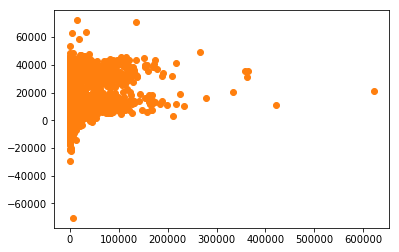

In [157]:
#######REGRESSION AND PREDICTION: Page-wise performance:
###ALT
import pandas as pd
from pandas.stats.api import ols
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import math
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.cross_validation import train_test_split
import math

from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

############ LOG SCALING - 
###PREDICTION TASK - with cross-promotion
###Cross-validation
train_df = pd.read_csv('previous-to-next-page-info.csv')
all_pages = list(train.buzz_account_display_name.unique())

print("WITH cross-promotion features")


# train_features = one_hour_features
train_features = cross_promotion_features + one_hour_features
# train_features = two_day_features + one_hour_features + cross_promotion_features

lm = linear_model.LinearRegression(fit_intercept=True)
# lm = linear_model.LinearRegression(fit_intercept=True, normalize=True)
cv = 10

train_df['clicks_bucket'] = np.log(train_df['ext_twodays_consumptions_by_type__link_clicks'] + 1).astype(int)
train_df['share_bucket'] = np.log(train_df['ext_twodays_stories_by_action_type__share']+1).astype(int)

print("No. of data-points = ", len(train_df))

y_clicks = train_df['next_clicks']
y_share = train_df['next_shares']
# y_clicks = train['clicks_bucket']
# y_share = train['share_bucket']

###generate DFs for analysis - X and Y
df = train_df[train_features]

# fit a model
model = lm

###prediction with cross validation
# Necessary imports: 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# 10-fold CV
# scores = cross_val_score(model, df, y_share, cv = 10)
# print("Cross-validated scores:", scores)
# print("Mean accuracy = ", scores.mean())

# Make cross validated predictions
y = y_share
predictions = cross_val_predict(model, df, y, cv=cv)

plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy (R2):", accuracy)

from sklearn.metrics import mean_absolute_error
# print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
error_percent = mean_absolute_error(y, predictions)/y.mean()
print("Mean values (share): ", y.mean(), " | percent error: ",  error_percent)

model = lm

###prediction with cross validation
# Necessary imports: 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# # 10-fold CV
# scores = cross_val_score(model, df, y_clicks, cv = 10)
# print("Cross-validated scores:", scores)
# print("Mean accuracy = ", scores.mean())

y = y_clicks
# Make cross validated predictions
predictions = cross_val_predict(model, df, y, cv=cv)

plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy (R2):", accuracy)

from sklearn.metrics import mean_absolute_error
# print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
error_percent = mean_absolute_error(y, predictions)/y.mean()
print("Mean values (clicks): ", y.mean(), " | percent error: ",  error_percent)
###get coefficients
#     import numpy as np
#     print(pd.concat([pd.DataFrame(df.columns),pd.DataFrame(np.transpose(lm.coef_))], axis = 1))

WITH cross-promotion features
No. of data-points =  18438
Cross-Predicted Accuracy (R2): 0.426619198275
Mean values (share):  2.236196984488556  | percent error:  0.463546771197
Cross-Predicted Accuracy (R2): 0.446548329247
Mean values (clicks):  6.531999132226923  | percent error:  0.198195161213


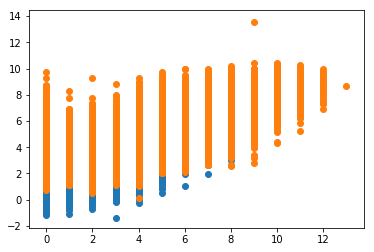

In [158]:
#######REGRESSION AND PREDICTION: Page-wise performance:
###ALT
import pandas as pd
from pandas.stats.api import ols
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import math
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.cross_validation import train_test_split
import math

from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

############ LOG SCALING - 
###PREDICTION TASK - with cross-promotion
###Cross-validation
train_df = pd.read_csv('previous-to-next-page-info.csv')
all_pages = list(train.buzz_account_display_name.unique())

print("WITH cross-promotion features")


# train_features = one_hour_features
train_features = cross_promotion_features + one_hour_features
# train_features = two_day_features + one_hour_features + cross_promotion_features

for feats in (two_day_features + one_hour_features):
    train_df[feats] = np.log(train_df[feats] + 1)

lm = linear_model.LinearRegression(fit_intercept=True)
# lm = linear_model.LinearRegression(fit_intercept=True, normalize=True)
cv = 10

train_df['clicks_bucket'] = np.log(train_df['next_clicks'] + 1).astype(int)
train_df['share_bucket'] = np.log(train_df['next_shares']+1).astype(int)

print("No. of data-points = ", len(train_df))

# y_clicks = train_df['next_clicks']
# y_share = train_df['next_shares']
y_clicks = train_df['clicks_bucket']
y_share = train_df['share_bucket']

###generate DFs for analysis - X and Y
df = train_df[train_features]

# fit a model
model = lm

###prediction with cross validation
# Necessary imports: 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# 10-fold CV
# scores = cross_val_score(model, df, y_share, cv = 10)
# print("Cross-validated scores:", scores)
# print("Mean accuracy = ", scores.mean())

# Make cross validated predictions
y = y_share
predictions = cross_val_predict(model, df, y, cv=cv)

plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy (R2):", accuracy)

from sklearn.metrics import mean_absolute_error
# print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
error_percent = mean_absolute_error(y, predictions)/y.mean()
print("Mean values (share): ", y.mean(), " | percent error: ",  error_percent)

model = lm

###prediction with cross validation
# Necessary imports: 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# # 10-fold CV
# scores = cross_val_score(model, df, y_clicks, cv = 10)
# print("Cross-validated scores:", scores)
# print("Mean accuracy = ", scores.mean())

y = y_clicks
# Make cross validated predictions
predictions = cross_val_predict(model, df, y, cv=cv)

plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy (R2):", accuracy)

from sklearn.metrics import mean_absolute_error
# print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
error_percent = mean_absolute_error(y, predictions)/y.mean()
print("Mean values (clicks): ", y.mean(), " | percent error: ",  error_percent)
###get coefficients
#     import numpy as np
#     print(pd.concat([pd.DataFrame(df.columns),pd.DataFrame(np.transpose(lm.coef_))], axis = 1))

In [ ]:
#######REGRESSION AND PREDICTION: Page-wise performance:
###ALT
import pandas as pd
from pandas.stats.api import ols
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import math
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.cross_validation import train_test_split
import math

from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

############ LOG SCALING - 
###PREDICTION TASK - with cross-promotion
###Cross-validation
train_df = pd.read_csv('previous-to-next-page-info.csv')
all_pages = list(train.buzz_account_display_name.unique())

print("WITH cross-promotion features")


# train_features = one_hour_features
# train_features = two_day_features + one_hour_features
train_features = two_day_features + one_hour_features + cross_promotion_features

for feats in (two_day_features + one_hour_features):
    train_df[feats] = np.log(train_df[feats] + 1)

lm = linear_model.LinearRegression(fit_intercept=True)
# lm = linear_model.LinearRegression(fit_intercept=True, normalize=True)
cv = 10

train_df['clicks_bucket'] = np.log(train_df['next_clicks'] + 1).astype(int)
train_df['share_bucket'] = np.log(train_df['next_shares']+1).astype(int)

print("No. of data-points = ", len(train_df))

# y_clicks = train_df['next_clicks']
# y_share = train_df['next_shares']
y_clicks = train_df['clicks_bucket']
y_share = train_df['share_bucket']

###generate DFs for analysis - X and Y
df = train_df[train_features]

# fit a model
model = lm

###prediction with cross validation
# Necessary imports: 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# 10-fold CV
# scores = cross_val_score(model, df, y_share, cv = 10)
# print("Cross-validated scores:", scores)
# print("Mean accuracy = ", scores.mean())

# Make cross validated predictions
y = y_share
predictions = cross_val_predict(model, df, y, cv=cv)

plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy (R2):", accuracy)

from sklearn.metrics import mean_absolute_error
# print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
error_percent = mean_absolute_error(y, predictions)/y.mean()
print("Mean values (share): ", y.mean(), " | percent error: ",  error_percent)

model = lm

###prediction with cross validation
# Necessary imports: 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# # 10-fold CV
# scores = cross_val_score(model, df, y_clicks, cv = 10)
# print("Cross-validated scores:", scores)
# print("Mean accuracy = ", scores.mean())

y = y_clicks
# Make cross validated predictions
predictions = cross_val_predict(model, df, y, cv=cv)

plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy (R2):", accuracy)

from sklearn.metrics import mean_absolute_error
# print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
error_percent = mean_absolute_error(y, predictions)/y.mean()
print("Mean values (clicks): ", y.mean(), " | percent error: ",  error_percent)
###get coefficients
#     import numpy as np
#     print(pd.concat([pd.DataFrame(df.columns),pd.DataFrame(np.transpose(lm.coef_))], axis = 1))

WITH cross-promotion features
TREE REGRESSION!
No. of data-points =  18438
Cross-Predicted Accuracy (R2): 0.414460779201
Mean values (share):  2.236196984488556  | percent error:  0.469112239125
Cross-Predicted Accuracy (R2): 0.402844383341
Mean values (clicks):  6.531999132226923  | percent error:  0.207739474137


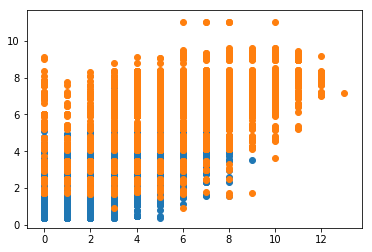

In [163]:
#######REGRESSION AND PREDICTION: Page-wise performance:
###ALT
import pandas as pd
from pandas.stats.api import ols
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import math
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.cross_validation import train_test_split
import math

from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

############ LOG SCALING - 
###PREDICTION TASK - with cross-promotion
###Cross-validation
train_df = pd.read_csv('previous-to-next-page-info.csv')
all_pages = list(train.buzz_account_display_name.unique())

print("WITH cross-promotion features")


# train_features = one_hour_features
# train_features = two_day_features + one_hour_features
train_features = two_day_features + one_hour_features + cross_promotion_features

for feats in (two_day_features + one_hour_features):
    train_df[feats] = np.log(train_df[feats] + 1)

from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth=5)

print("TREE REGRESSION!")

# lm = linear_model.LinearRegression(fit_intercept=True, normalize=True)
cv = 10

train_df['clicks_bucket'] = np.log(train_df['next_clicks'] + 1).astype(int)
train_df['share_bucket'] = np.log(train_df['next_shares']+1).astype(int)

print("No. of data-points = ", len(train_df))

# y_clicks = train_df['next_clicks']
# y_share = train_df['next_shares']
y_clicks = train_df['clicks_bucket']
y_share = train_df['share_bucket']

###generate DFs for analysis - X and Y
df = train_df[train_features]

# fit a model
model = clf

###prediction with cross validation
# Necessary imports: 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# 10-fold CV
# scores = cross_val_score(model, df, y_share, cv = 10)
# print("Cross-validated scores:", scores)
# print("Mean accuracy = ", scores.mean())

# Make cross validated predictions
y = y_share
predictions = cross_val_predict(model, df, y, cv=cv)

plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy (R2):", accuracy)

from sklearn.metrics import mean_absolute_error
# print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
error_percent = mean_absolute_error(y, predictions)/y.mean()
print("Mean values (share): ", y.mean(), " | percent error: ",  error_percent)

model = clf

###prediction with cross validation
# Necessary imports: 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# # 10-fold CV
# scores = cross_val_score(model, df, y_clicks, cv = 10)
# print("Cross-validated scores:", scores)
# print("Mean accuracy = ", scores.mean())

y = y_clicks
# Make cross validated predictions
predictions = cross_val_predict(model, df, y, cv=cv)

plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy (R2):", accuracy)

from sklearn.metrics import mean_absolute_error
# print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
error_percent = mean_absolute_error(y, predictions)/y.mean()
print("Mean values (clicks): ", y.mean(), " | percent error: ",  error_percent)
###get coefficients
#     import numpy as np
#     print(pd.concat([pd.DataFrame(df.columns),pd.DataFrame(np.transpose(lm.coef_))], axis = 1))

LINEAR REGRESSION!
WITH cross-promotion features
No. of data-points =  18438
Cross-Predicted Accuracy (R2): 0.426619198275
Mean values (share):  2.236196984488556  | percent error:  0.463546771197
Cross-Predicted Accuracy (R2): 0.446548329247
Mean values (clicks):  6.531999132226923  | percent error:  0.198195161213


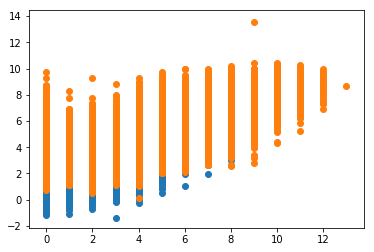

In [164]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
print("LINEAR REGRESSION!")

#######REGRESSION AND PREDICTION: Page-wise performance:
###ALT
import pandas as pd
from pandas.stats.api import ols
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import math
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.cross_validation import train_test_split
import math

from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

############ LOG SCALING - 
###PREDICTION TASK - with cross-promotion
###Cross-validation
train_df = pd.read_csv('previous-to-next-page-info.csv')
all_pages = list(train.buzz_account_display_name.unique())

print("WITH cross-promotion features")


# train_features = one_hour_features
train_features = cross_promotion_features + one_hour_features
# train_features = two_day_features + one_hour_features + cross_promotion_features

for feats in (two_day_features + one_hour_features):
    train_df[feats] = np.log(train_df[feats] + 1)

# lm = linear_model.LinearRegression(fit_intercept=True, normalize=True)
cv = 10

train_df['clicks_bucket'] = np.log(train_df['next_clicks'] + 1).astype(int)
train_df['share_bucket'] = np.log(train_df['next_shares']+1).astype(int)

print("No. of data-points = ", len(train_df))

# y_clicks = train_df['next_clicks']
# y_share = train_df['next_shares']
y_clicks = train_df['clicks_bucket']
y_share = train_df['share_bucket']

###generate DFs for analysis - X and Y
df = train_df[train_features]

# fit a model
model = clf

###prediction with cross validation
# Necessary imports: 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# 10-fold CV
# scores = cross_val_score(model, df, y_share, cv = 10)
# print("Cross-validated scores:", scores)
# print("Mean accuracy = ", scores.mean())

# Make cross validated predictions
y = y_share
predictions = cross_val_predict(model, df, y, cv=cv)

plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy (R2):", accuracy)

from sklearn.metrics import mean_absolute_error
# print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
error_percent = mean_absolute_error(y, predictions)/y.mean()
print("Mean values (share): ", y.mean(), " | percent error: ",  error_percent)

model = clf

###prediction with cross validation
# Necessary imports: 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# # 10-fold CV
# scores = cross_val_score(model, df, y_clicks, cv = 10)
# print("Cross-validated scores:", scores)
# print("Mean accuracy = ", scores.mean())

y = y_clicks
# Make cross validated predictions
predictions = cross_val_predict(model, df, y, cv=cv)

plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy (R2):", accuracy)

from sklearn.metrics import mean_absolute_error
# print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
error_percent = mean_absolute_error(y, predictions)/y.mean()
print("Mean values (clicks): ", y.mean(), " | percent error: ",  error_percent)
###get coefficients
#     import numpy as np
#     print(pd.concat([pd.DataFrame(df.columns),pd.DataFrame(np.transpose(lm.coef_))], axis = 1))

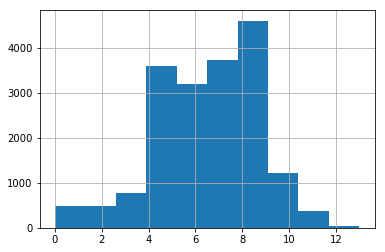

In [237]:
y_clicks.hist()

In [175]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

print("LINEAR REGRESSION!")

train_df = pd.read_csv('previous-to-next-page-info.csv')
all_pages = list(train.buzz_account_display_name.unique())

print("WITH cross-promotion features")


# train_features = one_hour_features
train_features = cross_promotion_features + one_hour_features
# train_features = two_day_features + one_hour_features + cross_promotion_features

# for feats in (two_day_features + one_hour_features):
#     train_df[feats] = np.log(train_df[feats] + 1)

# lm = linear_model.LinearRegression(fit_intercept=True, normalize=True)
cv = 10

train_df['clicks_bucket'] = np.log(train_df['next_clicks'] + 1).astype(int)
train_df['share_bucket'] = np.log(train_df['next_shares']+1).astype(int)

print("No. of data-points = ", len(train_df))

y_clicks = train_df['next_clicks']
y_share = train_df['next_shares']
# y_clicks = train_df['clicks_bucket']
# y_share = train_df['share_bucket']

###generate DFs for analysis - X and Y
X = train_df[train_features]

from sklearn.model_selection import KFold

fold = 0
cv_folds = 10
kf = KFold(n_splits = cv_folds, shuffle = True)

clicks_accuracy = []
clicks_error = []
shares_accuracy = []
shares_error = []

for train_index, test_index in kf.split(X):
    print("Shares: Fold = ", fold)
    y = y_share
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
        
    accuracy = metrics.r2_score(y_test, y_pred)
    print("Cross-Predicted Accuracy (R2):", accuracy)
    shares_accuracy.append(accuracy)
    from sklearn.metrics import mean_absolute_error
    # print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
    error_percent = mean_absolute_error(y_test, y_pred)/y.mean()
    print("Mean values (share): ", y_test.mean(), " | percent error: ",  error_percent)
    shares_error.append(error_percent)
    
    print("Clicks: Fold = ", fold)
    y = y_clicks
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    
    accuracy = metrics.r2_score(y_test, y_pred)
    print("Cross-Predicted Accuracy (R2):", accuracy)
    clicks_accuracy.append(accuracy)
    from sklearn.metrics import mean_absolute_error
    # print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
    error_percent = mean_absolute_error(y_test, y_pred)/y.mean()
    print("Mean values (share): ", y_test.mean(), " | percent error: ",  error_percent)
    clicks_error.append(error_percent)
    fold += 1
print("Shares performance: Accuracy = ", np.mean(shares_accuracy), " ; Error (/100) = ", np.mean(shares_error))
print("Clicks performance: Accuracy = ", np.mean(clicks_accuracy), " ; Error (/100) = ", np.mean(clicks_error))

LINEAR REGRESSION!
WITH cross-promotion features
No. of data-points =  18438
Shares: Fold =  0
Cross-Predicted Accuracy (R2): 0.122479822261
Mean values (share):  79.98698481561821  | percent error:  1.18600147443
Clicks: Fold =  0
Cross-Predicted Accuracy (R2): 0.141182443455
Mean values (share):  7290.318872017354  | percent error:  1.10557836541
Shares: Fold =  1
Cross-Predicted Accuracy (R2): 0.130958773834
Mean values (share):  66.40455531453362  | percent error:  1.03141715081
Clicks: Fold =  1
Cross-Predicted Accuracy (R2): 0.185877402397
Mean values (share):  7163.382321041215  | percent error:  1.10070284418
Shares: Fold =  2
Cross-Predicted Accuracy (R2): 0.106246922375
Mean values (share):  74.79989154013015  | percent error:  1.14805009728
Clicks: Fold =  2
Cross-Predicted Accuracy (R2): 0.160445085335
Mean values (share):  6335.194685466377  | percent error:  1.01856427762
Shares: Fold =  3
Cross-Predicted Accuracy (R2): 0.105594390926
Mean values (share):  78.112798264642

In [198]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth = 10)

print("TREE REGRESSION!")

train_df = pd.read_csv('previous-to-next-page-info.csv')
all_pages = list(train.buzz_account_display_name.unique())

print("WITH cross-promotion features")


# train_features = one_hour_features
train_features = cross_promotion_features + one_hour_features
# train_features = two_day_features + one_hour_features + cross_promotion_features

# for feats in (two_day_features + one_hour_features):
#     train_df[feats] = np.log(train_df[feats] + 1)

# lm = linear_model.LinearRegression(fit_intercept=True, normalize=True)
cv = 10

train_df['clicks_bucket'] = np.log(train_df['next_clicks'] + 1).astype(int)
train_df['share_bucket'] = np.log(train_df['next_shares']+1).astype(int)

print("No. of data-points = ", len(train_df))

y_clicks = train_df['next_clicks']
y_share = train_df['next_shares']
# y_clicks = train_df['clicks_bucket']
# y_share = train_df['share_bucket']

###generate DFs for analysis - X and Y
X = train_df[train_features]

from sklearn.model_selection import KFold

fold = 0
cv_folds = 10
kf = KFold(n_splits = cv_folds, shuffle = True)

clicks_accuracy = []
clicks_error = []
shares_accuracy = []
shares_error = []

for train_index, test_index in kf.split(X):
    print("Shares: Fold = ", fold)
    y = y_share
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
        
    accuracy = metrics.r2_score(y_test, y_pred)
    print("Cross-Predicted Accuracy (R2):", accuracy)
    shares_accuracy.append(accuracy)
    from sklearn.metrics import mean_absolute_error
    # print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
    error_percent = mean_absolute_error(y_test, y_pred)/y.mean()
    print("Mean values (share): ", y_test.mean(), " | percent error: ",  error_percent)
    shares_error.append(error_percent)
    
    print("Clicks: Fold = ", fold)
    y = y_clicks
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    
    accuracy = metrics.r2_score(y_test, y_pred)
    print("Cross-Predicted Accuracy (R2):", accuracy)
    clicks_accuracy.append(accuracy)
    from sklearn.metrics import mean_absolute_error
    # print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
    error_percent = mean_absolute_error(y_test, y_pred)/y.mean()
    print("Mean values (share): ", y_test.mean(), " | percent error: ",  error_percent)
    clicks_error.append(error_percent)
    fold += 1
print("Shares performance: Accuracy = ", np.mean(shares_accuracy), " ; Error (/100) = ", np.mean(shares_error))
print("Clicks performance: Accuracy = ", np.mean(clicks_accuracy), " ; Error (/100) = ", np.mean(clicks_error))

TREE REGRESSION!
WITH cross-promotion features
No. of data-points =  18438
Shares: Fold =  0
Cross-Predicted Accuracy (R2): 0.59574732365
Mean values (share):  70.20770065075922  | percent error:  0.696792112964
Clicks: Fold =  0
Cross-Predicted Accuracy (R2): 0.590520633303
Mean values (share):  7281.183839479392  | percent error:  0.774663522858
Shares: Fold =  1
Cross-Predicted Accuracy (R2): 0.704597228331
Mean values (share):  77.70119305856834  | percent error:  0.705381277693
Clicks: Fold =  1
Cross-Predicted Accuracy (R2): 0.690910502842
Mean values (share):  6474.418655097614  | percent error:  0.682802317974
Shares: Fold =  2
Cross-Predicted Accuracy (R2): 0.56958153977
Mean values (share):  66.05260303687636  | percent error:  0.675250093649
Clicks: Fold =  2
Cross-Predicted Accuracy (R2): 0.505780968505
Mean values (share):  7127.255965292841  | percent error:  0.788092382993
Shares: Fold =  3
Cross-Predicted Accuracy (R2): 0.779655805733
Mean values (share):  80.3703904555

In [176]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)

print("RIDGE REGRESSION!")

train_df = pd.read_csv('previous-to-next-page-info.csv')
all_pages = list(train.buzz_account_display_name.unique())

print("WITH cross-promotion features")


# train_features = one_hour_features
train_features = cross_promotion_features + one_hour_features
# train_features = two_day_features + one_hour_features + cross_promotion_features

# for feats in (two_day_features + one_hour_features):
#     train_df[feats] = np.log(train_df[feats] + 1)

# lm = linear_model.LinearRegression(fit_intercept=True, normalize=True)
cv = 10

train_df['clicks_bucket'] = np.log(train_df['next_clicks'] + 1).astype(int)
train_df['share_bucket'] = np.log(train_df['next_shares']+1).astype(int)

print("No. of data-points = ", len(train_df))

y_clicks = train_df['next_clicks']
y_share = train_df['next_shares']
# y_clicks = train_df['clicks_bucket']
# y_share = train_df['share_bucket']

###generate DFs for analysis - X and Y
X = train_df[train_features]

from sklearn.model_selection import KFold

fold = 0
cv_folds = 10
kf = KFold(n_splits = cv_folds, shuffle = True)

clicks_accuracy = []
clicks_error = []
shares_accuracy = []
shares_error = []

for train_index, test_index in kf.split(X):
    print("Shares: Fold = ", fold)
    y = y_share
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
        
    accuracy = metrics.r2_score(y_test, y_pred)
    print("Cross-Predicted Accuracy (R2):", accuracy)
    shares_accuracy.append(accuracy)
    from sklearn.metrics import mean_absolute_error
    # print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
    error_percent = mean_absolute_error(y_test, y_pred)/y.mean()
    print("Mean values (share): ", y_test.mean(), " | percent error: ",  error_percent)
    shares_error.append(error_percent)
    
    print("Clicks: Fold = ", fold)
    y = y_clicks
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    
    accuracy = metrics.r2_score(y_test, y_pred)
    print("Cross-Predicted Accuracy (R2):", accuracy)
    clicks_accuracy.append(accuracy)
    from sklearn.metrics import mean_absolute_error
    # print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
    error_percent = mean_absolute_error(y_test, y_pred)/y.mean()
    print("Mean values (share): ", y_test.mean(), " | percent error: ",  error_percent)
    clicks_error.append(error_percent)
    fold += 1
print("Shares performance: Accuracy = ", np.mean(shares_accuracy), " ; Error (/100) = ", np.mean(shares_error))
print("Clicks performance: Accuracy = ", np.mean(clicks_accuracy), " ; Error (/100) = ", np.mean(clicks_error))

RIDGE REGRESSION!
WITH cross-promotion features
No. of data-points =  18438
Shares: Fold =  0
Cross-Predicted Accuracy (R2): 0.119097006527
Mean values (share):  71.29175704989154  | percent error:  1.13322686946
Clicks: Fold =  0
Cross-Predicted Accuracy (R2): 0.124425340887
Mean values (share):  7014.87906724512  | percent error:  1.11826399822
Shares: Fold =  1
Cross-Predicted Accuracy (R2): 0.147873925221
Mean values (share):  83.30422993492408  | percent error:  1.25204131077
Clicks: Fold =  1
Cross-Predicted Accuracy (R2): 0.19227199893
Mean values (share):  7894.810737527115  | percent error:  1.1800826627
Shares: Fold =  2
Cross-Predicted Accuracy (R2): 0.0885724038082
Mean values (share):  81.26898047722342  | percent error:  1.2206556496
Clicks: Fold =  2
Cross-Predicted Accuracy (R2): 0.196195686492
Mean values (share):  7315.024945770065  | percent error:  1.09845080704
Shares: Fold =  3
Cross-Predicted Accuracy (R2): 0.115259175166
Mean values (share):  81.58134490238612  

In [178]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
print("LASSO REGRESSION!")

train_df = pd.read_csv('previous-to-next-page-info.csv')
all_pages = list(train.buzz_account_display_name.unique())

print("WITH cross-promotion features")


# train_features = one_hour_features
train_features = cross_promotion_features + one_hour_features
# train_features = two_day_features + one_hour_features + cross_promotion_features

# for feats in (two_day_features + one_hour_features):
#     train_df[feats] = np.log(train_df[feats] + 1)

# lm = linear_model.LinearRegression(fit_intercept=True, normalize=True)
cv = 10

train_df['clicks_bucket'] = np.log(train_df['next_clicks'] + 1).astype(int)
train_df['share_bucket'] = np.log(train_df['next_shares']+1).astype(int)

print("No. of data-points = ", len(train_df))

y_clicks = train_df['next_clicks']
y_share = train_df['next_shares']
# y_clicks = train_df['clicks_bucket']
# y_share = train_df['share_bucket']

###generate DFs for analysis - X and Y
X = train_df[train_features]

from sklearn.model_selection import KFold

fold = 0
cv_folds = 10
kf = KFold(n_splits = cv_folds, shuffle = True)

clicks_accuracy = []
clicks_error = []
shares_accuracy = []
shares_error = []

for train_index, test_index in kf.split(X):
    print("Shares: Fold = ", fold)
    y = y_share
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
        
    accuracy = metrics.r2_score(y_test, y_pred)
    print("Cross-Predicted Accuracy (R2):", accuracy)
    shares_accuracy.append(accuracy)
    from sklearn.metrics import mean_absolute_error
    # print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
    error_percent = mean_absolute_error(y_test, y_pred)/y.mean()
    print("Mean values (share): ", y_test.mean(), " | percent error: ",  error_percent)
    shares_error.append(error_percent)
    
    print("Clicks: Fold = ", fold)
    y = y_clicks
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    
    accuracy = metrics.r2_score(y_test, y_pred)
    print("Cross-Predicted Accuracy (R2):", accuracy)
    clicks_accuracy.append(accuracy)
    from sklearn.metrics import mean_absolute_error
    # print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
    error_percent = mean_absolute_error(y_test, y_pred)/y.mean()
    print("Mean values (share): ", y_test.mean(), " | percent error: ",  error_percent)
    clicks_error.append(error_percent)
    fold += 1
print("Shares performance: Accuracy = ", np.mean(shares_accuracy), " ; Error (/100) = ", np.mean(shares_error))
print("Clicks performance: Accuracy = ", np.mean(clicks_accuracy), " ; Error (/100) = ", np.mean(clicks_error))

LASSO REGRESSION!
WITH cross-promotion features
No. of data-points =  18438
Shares: Fold =  0


/Users/eshwarchandrasekharan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Cross-Predicted Accuracy (R2): 0.0816822327227
Mean values (share):  70.1822125813449  | percent error:  1.10928738276
Clicks: Fold =  0
Cross-Predicted Accuracy (R2): 0.186730745927
Mean values (share):  6744.34327548807  | percent error:  1.05891431254
Shares: Fold =  1
Cross-Predicted Accuracy (R2): 0.156288674163
Mean values (share):  77.5119305856833  | percent error:  1.17632913582
Clicks: Fold =  1
Cross-Predicted Accuracy (R2): 0.198998128766
Mean values (share):  7635.841648590022  | percent error:  1.13875295895
Shares: Fold =  2
Cross-Predicted Accuracy (R2): 0.132074472705
Mean values (share):  73.5  | percent error:  1.11855126675
Clicks: Fold =  2
Cross-Predicted Accuracy (R2): 0.166345869851
Mean values (share):  6937.3731019522775  | percent error:  1.08155666874
Shares: Fold =  3
Cross-Predicted Accuracy (R2): 0.0638817107396
Mean values (share):  86.19034707158352  | percent error:  1.29992648137
Clicks: Fold =  3
Cross-Predicted Accuracy (R2): 0.13381576819
Mean valu

In [199]:
train_df

,next_external_id,buzz_external_id,buzz_account_display_name,ext_table1_consumptions_by_type__link_clicks,ext_table1_consumptions_by_type__other_clicks,ext_table1_reactions_like_total,ext_table1_stories_by_action_type__comment,ext_table1_stories_by_action_type__like,ext_table1_stories_by_action_type__share,ext_table1_engaged_fan,...,BuzzFeed Steven L.,The Try Guys,Ohmygod Yaaa,BuzzFeed Chloe,Nifty Science,next_page,next_clicks,next_shares,clicks_bucket,share_bucket
0,574931839201643_1806270176067797,571035253040893_1139107702900309,SOML,4757.0,628.0,57,4.0,90.0,13.0,4764,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed UK,3415.0,17.0,8,2
1,21898300328_10156148388685329,280467515620435_466071057060079,Obsessed by BuzzFeed,637.0,85.0,62,6.0,68.0,12.0,678,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed,12213.0,69.0,9,4
2,1431595910448704_1892206761054281,1614251518827491_1926130917639548,Tasty,80435.0,9881.0,1350,614.0,1574.0,137.0,83121,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed Canada,347.0,0.0,5,0
3,1318800798260799_2228337970640406,571035253040893_1139583309519415,SOML,596.0,115.0,31,12.0,43.0,11.0,726,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed Video,3345.0,61.0,8,4
4,667406426724032_1048539731944031,21898300328_10156148417375329,BuzzFeed,33360.0,17868.0,2121,159.0,5346.0,551.0,39527,...,89.0,89.0,89.0,89.0,89.0,Cocoa Butter,353.0,37.0,5,3
5,280467515620435_466142523719599,262059950576033_1301296203319064,BuzzFeed Celeb,111.0,24.0,0,4.0,0.0,0.0,125,...,89.0,89.0,89.0,89.0,89.0,Obsessed by BuzzFeed,121.0,0.0,4,0
6,224750834524198_469698423362770,21898300328_10156148686725329,BuzzFeed,16669.0,650.0,102,16.0,110.0,14.0,15548,...,89.0,89.0,89.0,89.0,89.0,Buy Me That,1034.0,2.0,6,1
7,1412984988933193_2015905888641097,618786471475708_1519804378040575,BuzzFeed News,4102.0,1971.0,394,49.0,655.0,41.0,5462,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed Australia,1027.0,5.0,6,1
8,560066014088988_1338328922929356,560066014088988_1338287176266864,BuzzFeed Quiz,2149.0,130.0,44,28.0,47.0,5.0,2017,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed Quiz,860.0,2.0,6,1
9,257431141042836_1302288899890383,254018121357088_1380598595365696,BuzzFeed Style,3295.0,302.0,352,13.0,422.0,63.0,3527,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed Rewind,2384.0,88.0,7,4


In [206]:
pd.get_dummies(data = train_df, columns=['buzz_account_display_name', 'next_page'])

,next_external_id,buzz_external_id,ext_table1_consumptions_by_type__link_clicks,ext_table1_consumptions_by_type__other_clicks,ext_table1_reactions_like_total,ext_table1_stories_by_action_type__comment,ext_table1_stories_by_action_type__like,ext_table1_stories_by_action_type__share,ext_table1_engaged_fan,ext_table1_fan_reach,...,next_page_Reasons to Smile,next_page_SOML,next_page_See Something Say Something,next_page_So Relatable,next_page_Tasty,next_page_Tasty Demais,next_page_Tasty Junior,next_page_Tasty Miam,next_page_Tasty One-Pot,next_page_The Try Guys
0,574931839201643_1806270176067797,571035253040893_1139107702900309,4757.0,628.0,57,4.0,90.0,13.0,4764,56919,...,0,0,0,0,0,0,0,0,0,0
1,21898300328_10156148388685329,280467515620435_466071057060079,637.0,85.0,62,6.0,68.0,12.0,678,14639,...,0,0,0,0,0,0,0,0,0,0
2,1431595910448704_1892206761054281,1614251518827491_1926130917639548,80435.0,9881.0,1350,614.0,1574.0,137.0,83121,2496210,...,0,0,0,0,0,0,0,0,0,0
3,1318800798260799_2228337970640406,571035253040893_1139583309519415,596.0,115.0,31,12.0,43.0,11.0,726,38871,...,0,0,0,0,0,0,0,0,0,0
4,667406426724032_1048539731944031,21898300328_10156148417375329,33360.0,17868.0,2121,159.0,5346.0,551.0,39527,457943,...,0,0,0,0,0,0,0,0,0,0
5,280467515620435_466142523719599,262059950576033_1301296203319064,111.0,24.0,0,4.0,0.0,0.0,125,5834,...,0,0,0,0,0,0,0,0,0,0
6,224750834524198_469698423362770,21898300328_10156148686725329,16669.0,650.0,102,16.0,110.0,14.0,15548,246819,...,0,0,0,0,0,0,0,0,0,0
7,1412984988933193_2015905888641097,618786471475708_1519804378040575,4102.0,1971.0,394,49.0,655.0,41.0,5462,80576,...,0,0,0,0,0,0,0,0,0,0
8,560066014088988_1338328922929356,560066014088988_1338287176266864,2149.0,130.0,44,28.0,47.0,5.0,2017,22104,...,0,0,0,0,0,0,0,0,0,0
9,257431141042836_1302288899890383,254018121357088_1380598595365696,3295.0,302.0,352,13.0,422.0,63.0,3527,53100,...,0,0,0,0,0,0,0,0,0,0


In [202]:
####label encoding
# le = sklearn.preprocessing.LabelEncoder()
# le.fit(["paris", "paris", "tokyo", "amsterdam"])
# le.transform(["tokyo", "tokyo", "paris"]) 

array([2, 2, 1])

In [236]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

print("LINEAR REGRESSION!")

train_df = pd.read_csv('previous-to-next-page-info.csv')
all_pages = list(train.buzz_account_display_name.unique())

print("WITH cross-promotion features")

page_infos = ['buzz_account_display_name', 'next_page']

# train_features = one_hour_features
train_features = one_hour_features + page_infos
# train_features = one_hour_features + page_infos + cross_promotion_features
# train_features = cross_promotion_features + one_hour_features
# train_features = two_day_features + one_hour_features + cross_promotion_features

for feats in (one_hour_features):
    train_df[feats] = np.log(train_df[feats] + 1)

# lm = linear_model.LinearRegression(fit_intercept=True, normalize=True)
cv = 10

train_df['clicks_bucket'] = np.log(train_df['next_clicks'] + 1).astype(int)
train_df['share_bucket'] = np.log(train_df['next_shares']+1).astype(int)

print("No. of data-points = ", len(train_df))

# y_clicks = train_df['next_clicks']
# y_share = train_df['next_shares']
y_clicks = train_df['clicks_bucket']
y_share = train_df['share_bucket']

###generate DFs for analysis - X and Y
X = train_df[train_features]
####convert page_infos into dummies
X = pd.get_dummies(data = X, columns=['buzz_account_display_name', 'next_page'])

from sklearn.model_selection import KFold

fold = 0
cv_folds = 10
kf = KFold(n_splits = cv_folds, shuffle = True)

clicks_accuracy = []
clicks_error = []
shares_accuracy = []
shares_error = []

for train_index, test_index in kf.split(X):
    print("Fold = ", fold)
#     print("Shares: Fold = ", fold)
    y = y_share
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
        
    accuracy = metrics.r2_score(y_test, y_pred)
#     print("Cross-Predicted Accuracy (R2):", accuracy)
    shares_accuracy.append(accuracy)
    from sklearn.metrics import mean_absolute_error
    # print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
    error_percent = mean_absolute_error(y_test, y_pred)/y.mean()
#     print("Mean values (share): ", y_test.mean(), " | percent error: ",  error_percent)
    shares_error.append(error_percent)
    
#     print("Clicks: Fold = ", fold)
    y = y_clicks
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    
    accuracy = metrics.r2_score(y_test, y_pred)
#     print("Cross-Predicted Accuracy (R2):", accuracy)
    clicks_accuracy.append(accuracy)
    from sklearn.metrics import mean_absolute_error
    # print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
    error_percent = mean_absolute_error(y_test, y_pred)/y.mean()
#     print("Mean values (share): ", y_test.mean(), " | percent error: ",  error_percent)
    clicks_error.append(error_percent)
    fold += 1
print("Shares performance: Accuracy = ", np.mean(shares_accuracy), " ; Error (/100) = ", np.mean(shares_error))
print("Clicks performance: Accuracy = ", np.mean(clicks_accuracy), " ; Error (/100) = ", np.mean(clicks_error))

LINEAR REGRESSION!
WITH cross-promotion features
No. of data-points =  18438
Fold =  0
Fold =  1
Fold =  2
Fold =  3
Fold =  4
Fold =  5
Fold =  6
Fold =  7
Fold =  8
Fold =  9
Shares performance: Accuracy =  0.744260965839  ; Error (/100) =  0.297658039096
Clicks performance: Accuracy =  0.767382854164  ; Error (/100) =  0.109083132912


In [231]:
print("ONLY 1 HOUR PERFORMANCE IN PREVIOUS PAGE")
print('SHARES:')
res = ols(y = y_share, x = X)
print(res)
print('CLICKS:')
res = ols(y =y_clicks, x = X)
print(res)

ONLY 1 HOUR PERFORMANCE IN PREVIOUS PAGE
SHARES:


/Users/eshwarchandrasekharan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://www.statsmodels.org/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/eshwarchandrasekharan/anaconda3/lib/python3.6/site-packages/pandas/stats/ols.py:336: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self._var_beta_raw))
/Users/eshwarchandrasekharan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/eshwarchandrasekharan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/eshwarchandrasekharan/anaconda3/


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <ext_table1_consumptions_by_type__link_clicks>
             + <ext_table1_consumptions_by_type__other_clicks> + <ext_table1_reactions_like_total>
             + <ext_table1_stories_by_action_type__comment>
             + <ext_table1_stories_by_action_type__like> + <ext_table1_stories_by_action_type__share>
             + <ext_table1_engaged_fan> + <ext_table1_fan_reach>
             + <ext_table1_impressions> + <ext_table1_impressions_fan>
             + <buzz_account_display_name_Adam Ellis> + <buzz_account_display_name_Another Round>
             + <buzz_account_display_name_Bien Tasty>
             + <buzz_account_display_name_Buy Me That> + <buzz_account_display_name_BuzzFeed>
             + <buzz_account_display_name_BuzzFeed Animals>
             + <buzz_account_display_name_BuzzFeed Australia> + <buzz_account_display_name_BuzzFeed BFF>
             + <buzz_account_display_name_BuzzFee

In [235]:
# from sklearn import linear_model
# clf = linear_model.LinearRegression()
# print("LINEAR REGRESSION!")

from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth = 10)
print("TREE REGRESSION!")

train_df = pd.read_csv('previous-to-next-page-info.csv')
all_pages = list(train.buzz_account_display_name.unique())

print("WITH cross-promotion features")

page_infos = ['buzz_account_display_name', 'next_page']

# train_features = one_hour_features
train_features = one_hour_features + page_infos
# train_features = one_hour_features + two_day_features + page_infos
# train_features = cross_promotion_features + one_hour_features + page_infos

# train_features = two_day_features + one_hour_features + cross_promotion_features

# for feats in (one_hour_features):
#     train_df[feats] = np.log(train_df[feats] + 1)

# lm = linear_model.LinearRegression(fit_intercept=True, normalize=True)
cv = 10

train_df['clicks_bucket'] = np.log(train_df['next_clicks'] + 1).astype(int)
train_df['share_bucket'] = np.log(train_df['next_shares']+1).astype(int)

print("No. of data-points = ", len(train_df))

y_clicks = train_df['next_clicks']
y_share = train_df['next_shares']
# y_clicks = train_df['clicks_bucket']
# y_share = train_df['share_bucket']

###generate DFs for analysis - X and Y
X = train_df[train_features]
####convert page_infos into dummies
X = pd.get_dummies(data = X, columns=['buzz_account_display_name', 'next_page'])

from sklearn.model_selection import KFold

fold = 0
cv_folds = 10
kf = KFold(n_splits = cv_folds, shuffle = True)

clicks_accuracy = []
clicks_error = []
shares_accuracy = []
shares_error = []

for train_index, test_index in kf.split(X):
    print("Fold = ", fold)
#     print("Shares: Fold = ", fold)
    y = y_share
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
        
    accuracy = metrics.r2_score(y_test, y_pred)
#     print("Cross-Predicted Accuracy (R2):", accuracy)
    shares_accuracy.append(accuracy)
    from sklearn.metrics import mean_absolute_error
    # print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
    error_percent = mean_absolute_error(y_test, y_pred)/y.mean()
#     print("Mean values (share): ", y_test.mean(), " | percent error: ",  error_percent)
    shares_error.append(error_percent)
    
#     print("Clicks: Fold = ", fold)
    y = y_clicks
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    
    accuracy = metrics.r2_score(y_test, y_pred)
#     print("Cross-Predicted Accuracy (R2):", accuracy)
    clicks_accuracy.append(accuracy)
    from sklearn.metrics import mean_absolute_error
    # print("Mean Absolute Error: ", mean_absolute_error(y, predictions))
    error_percent = mean_absolute_error(y_test, y_pred)/y.mean()
#     print("Mean values (share): ", y_test.mean(), " | percent error: ",  error_percent)
    clicks_error.append(error_percent)
    fold += 1
print("Shares performance: Accuracy = ", np.mean(shares_accuracy), " ; Error (/100) = ", np.mean(shares_error))
print("Clicks performance: Accuracy = ", np.mean(clicks_accuracy), " ; Error (/100) = ", np.mean(clicks_error))

TREE REGRESSION!
WITH cross-promotion features
No. of data-points =  18438
Fold =  0
Fold =  1
Fold =  2
Fold =  3
Fold =  4
Fold =  5
Fold =  6
Fold =  7
Fold =  8
Fold =  9
Shares performance: Accuracy =  0.857752875432  ; Error (/100) =  0.513160221186
Clicks performance: Accuracy =  0.845698078849  ; Error (/100) =  0.420027252572


In [228]:
train_df

,next_external_id,buzz_external_id,buzz_account_display_name,ext_table1_consumptions_by_type__link_clicks,ext_table1_consumptions_by_type__other_clicks,ext_table1_reactions_like_total,ext_table1_stories_by_action_type__comment,ext_table1_stories_by_action_type__like,ext_table1_stories_by_action_type__share,ext_table1_engaged_fan,...,BuzzFeed Steven L.,The Try Guys,Ohmygod Yaaa,BuzzFeed Chloe,Nifty Science,next_page,next_clicks,next_shares,clicks_bucket,share_bucket
0,574931839201643_1806270176067797,571035253040893_1139107702900309,SOML,4757.0,628.0,57,4.0,90.0,13.0,4764,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed UK,3415.0,17.0,8,2
1,21898300328_10156148388685329,280467515620435_466071057060079,Obsessed by BuzzFeed,637.0,85.0,62,6.0,68.0,12.0,678,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed,12213.0,69.0,9,4
2,1431595910448704_1892206761054281,1614251518827491_1926130917639548,Tasty,80435.0,9881.0,1350,614.0,1574.0,137.0,83121,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed Canada,347.0,0.0,5,0
3,1318800798260799_2228337970640406,571035253040893_1139583309519415,SOML,596.0,115.0,31,12.0,43.0,11.0,726,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed Video,3345.0,61.0,8,4
4,667406426724032_1048539731944031,21898300328_10156148417375329,BuzzFeed,33360.0,17868.0,2121,159.0,5346.0,551.0,39527,...,89.0,89.0,89.0,89.0,89.0,Cocoa Butter,353.0,37.0,5,3
5,280467515620435_466142523719599,262059950576033_1301296203319064,BuzzFeed Celeb,111.0,24.0,0,4.0,0.0,0.0,125,...,89.0,89.0,89.0,89.0,89.0,Obsessed by BuzzFeed,121.0,0.0,4,0
6,224750834524198_469698423362770,21898300328_10156148686725329,BuzzFeed,16669.0,650.0,102,16.0,110.0,14.0,15548,...,89.0,89.0,89.0,89.0,89.0,Buy Me That,1034.0,2.0,6,1
7,1412984988933193_2015905888641097,618786471475708_1519804378040575,BuzzFeed News,4102.0,1971.0,394,49.0,655.0,41.0,5462,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed Australia,1027.0,5.0,6,1
8,560066014088988_1338328922929356,560066014088988_1338287176266864,BuzzFeed Quiz,2149.0,130.0,44,28.0,47.0,5.0,2017,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed Quiz,860.0,2.0,6,1
9,257431141042836_1302288899890383,254018121357088_1380598595365696,BuzzFeed Style,3295.0,302.0,352,13.0,422.0,63.0,3527,...,89.0,89.0,89.0,89.0,89.0,BuzzFeed Rewind,2384.0,88.0,7,4


In [242]:
X = '1433294486996353_1837077343284730'
url = 'https://api-public.buzzfeed.com/omnisearch/search/videos'
headers = { 'X-Auth-Token': 'ef2a7012-835f-4b5a-b527-22be59815e10'}
import requests
query = 'facebook__' + X.split('_')[1]
params = {'platform_ids': query, 'page_size': 1}
resp = requests.get(url, headers = headers, params = params).json().get('results',[])
df = pd.DataFrame(resp)
print("External ID: ", X, " ;  Unique content ID:", df['_content_id'].values[0])

KeyError: '_content_id'